In [7]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import os
import glob
import random
import scipy
import scipy.io
np.set_printoptions(threshold=np.nan)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
   

In [0]:
# Maximum no of tries
max_tries = 10000  
# Type of pooling. Avg recommended for reconstruction
pooling = 'avg'

In [0]:
# Layer names
VGG19_LAYERS = (
    'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

    'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

    'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
    'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

    'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
    'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

    'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
    'relu5_3', 'conv5_4', 'relu5_4'
)

In [0]:

def net_preloaded(weights, input_image, pooling):
    net = {}
    current = input_image
    for i, name in enumerate(VGG19_LAYERS):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current, pooling)
        net[name] = current

    assert len(net) == len(VGG19_LAYERS)
    return net

def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)


def _pool_layer(input, pooling):
    if pooling == 'avg':
        return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                padding='SAME')
    else:
        return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
                padding='SAME')

In [0]:
def read_image(file, scale_w=0, scale_h=0):
    img = scipy.misc.imread(file, mode='RGB').astype(np.float32)
    if (scale_w*scale_h):
        img = scipy.misc.imresize(img, [scale_w, scale_h])
    return img

In [0]:
def load_net(data_path):
    data = scipy.io.loadmat(data_path)
    if not all(i in data for i in ('layers', 'classes', 'normalization')):
        raise ValueError("You're using the wrong VGG19 data. Please follow the instructions in the README to download the correct data.")
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data['layers'][0]
    return weights, mean_pixel

vgg_mean_pixel :  [123.68  116.779 103.939]


/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


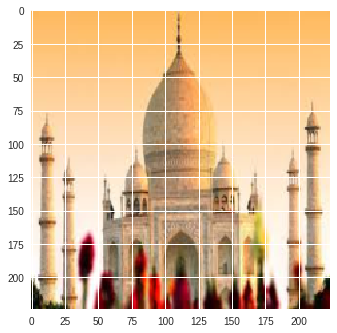

Image shape :  (1, 224, 224, 3)


In [15]:
#Optinal code
global_step = tf.Variable(0, trainable=False, name='global_step')


### Load pre-trained VGG wieghts
vgg_weights, vgg_mean_pixel = load_net("...\imagenet-vgg-verydeep-19.mat")
print ("vgg_mean_pixel : ", vgg_mean_pixel)


#Read input
img = read_image("Taj.png", 224, 224)
plt.imshow(img)
plt.show()

img = img - vgg_mean_pixel
img = img.astype(np.float32)

img = np.expand_dims(img, axis=0)   # extend shape for VGG input
img_shape=np.shape(img)

# Show original image
print ("Image shape : ", np.shape(img))

In [ ]:

### Compute content feature of 'invert_layer'
X_content_feature={}
content_graph = tf.Graph()
with content_graph.as_default():
    sess = tf.Session()
    X_content = tf.placeholder('float32', shape=img_shape)
    network = net_preloaded(vgg_weights, img, pooling)
    X_content_feature = sess.run(network["conv5_1"], feed_dict={X_content:img})


X = tf.Variable(tf.random_normal(img_shape))
invert_net = net_preloaded(vgg_weights, X, pooling)
X_invert_feature = invert_net["conv5_1"]

l2_loss = tf.norm(X_content_feature-X_invert_feature, 'euclidean')/tf.norm(X_content_feature, 'euclidean')
total_variation_loss = tf.reduce_sum(tf.image.total_variation(tf.convert_to_tensor(img+X)))
sigma_tv = 5e-7
loss = l2_loss + sigma_tv*total_variation_loss

train_step = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.5).minimize(loss, global_step = global_step)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:

for step in range(100000):  

    _ , _loss = sess.run([train_step, loss])      
    print("step: %06d"%step, "loss: {:.04}".format(_loss) )

   
    if not (step)%1000: 
        this_X = sess.run(X)
        this_X = this_X + vgg_mean_pixel
        plt.imshow(np.uint8(this_X[0]))
        plt.show()

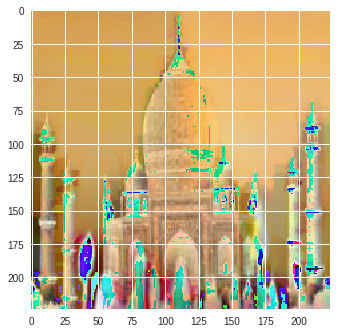

In [18]:
# Reconstructed image
plt.imshow(np.uint8(this_X[0]))
